In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
import os
import seaborn as sns

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

In [22]:
from src.toy.synthetic import create_simulator
from src.toy.synthetic import get_prior
from sbi.utils.user_input_checks import process_prior, process_simulator
from src.inference.utils import load_model

prior = get_prior()
simulator = create_simulator()
density_estimator = load_model(os.path.join("..", "results", "inference", "trained_model_15.pkl"))

prior, _, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)

c:\users\julian\documents\cmb-sbi-inference\src\inference\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [14]:
from sbi.inference import SNPE_C, simulate_for_sbi

true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)

inference = SNPE_C(prior=prior)
proposal = prior
num_rounds = 2
num_simulations=5000
samples = []

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal=proposal, num_simulations=num_simulations, num_workers=11)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_observed)
    samples.append(posterior.sample((25000,)))
    proposal = posterior

print(samples)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:02<00:00, 2230.00it/s]


 Neural network successfully converged after 147 epochs.

Drawing 25000 posterior samples: 27500it [00:01, 23245.79it/s]                           
100%|██████████| 5000/5000 [00:02<00:00, 2321.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 148 epochs.

Drawing 25000 posterior samples: 27500it [00:01, 23217.65it/s]                           

[tensor([[10.5033,  1.7484,  2.5372,  1.1013,  1.0044],
        [10.5011,  1.7488,  2.5389,  1.1007,  1.0025],
        [10.5013,  1.7497,  2.5457,  1.1008,  1.0008],
        ...,
        [10.4997,  1.7493,  2.5412,  1.1009,  1.0029],
        [10.4975,  1.7490,  2.5366,  1.1009,  1.0001],
        [10.4991,  1.7494,  2.5574,  1.1010,  1.0003]]), tensor([[10.4948,  1.7500,  2.5485,  1.0898,  0.9981],
        [10.4991,  1.7500,  2.5529,  1.0882,  0.9971],
        [10.5022,  1.7498,  2.5491,  1.0882,  0.9966],
        ...,
        [10.4982,  1.7497,  2.5448,  1.0904,  0.9969],
        [10.4967,  1.7498,  2.5467,  1.0886,  0.9965],
        [10.5012,  1.7499,  2.5527,  1.0872,  0.9984]])]


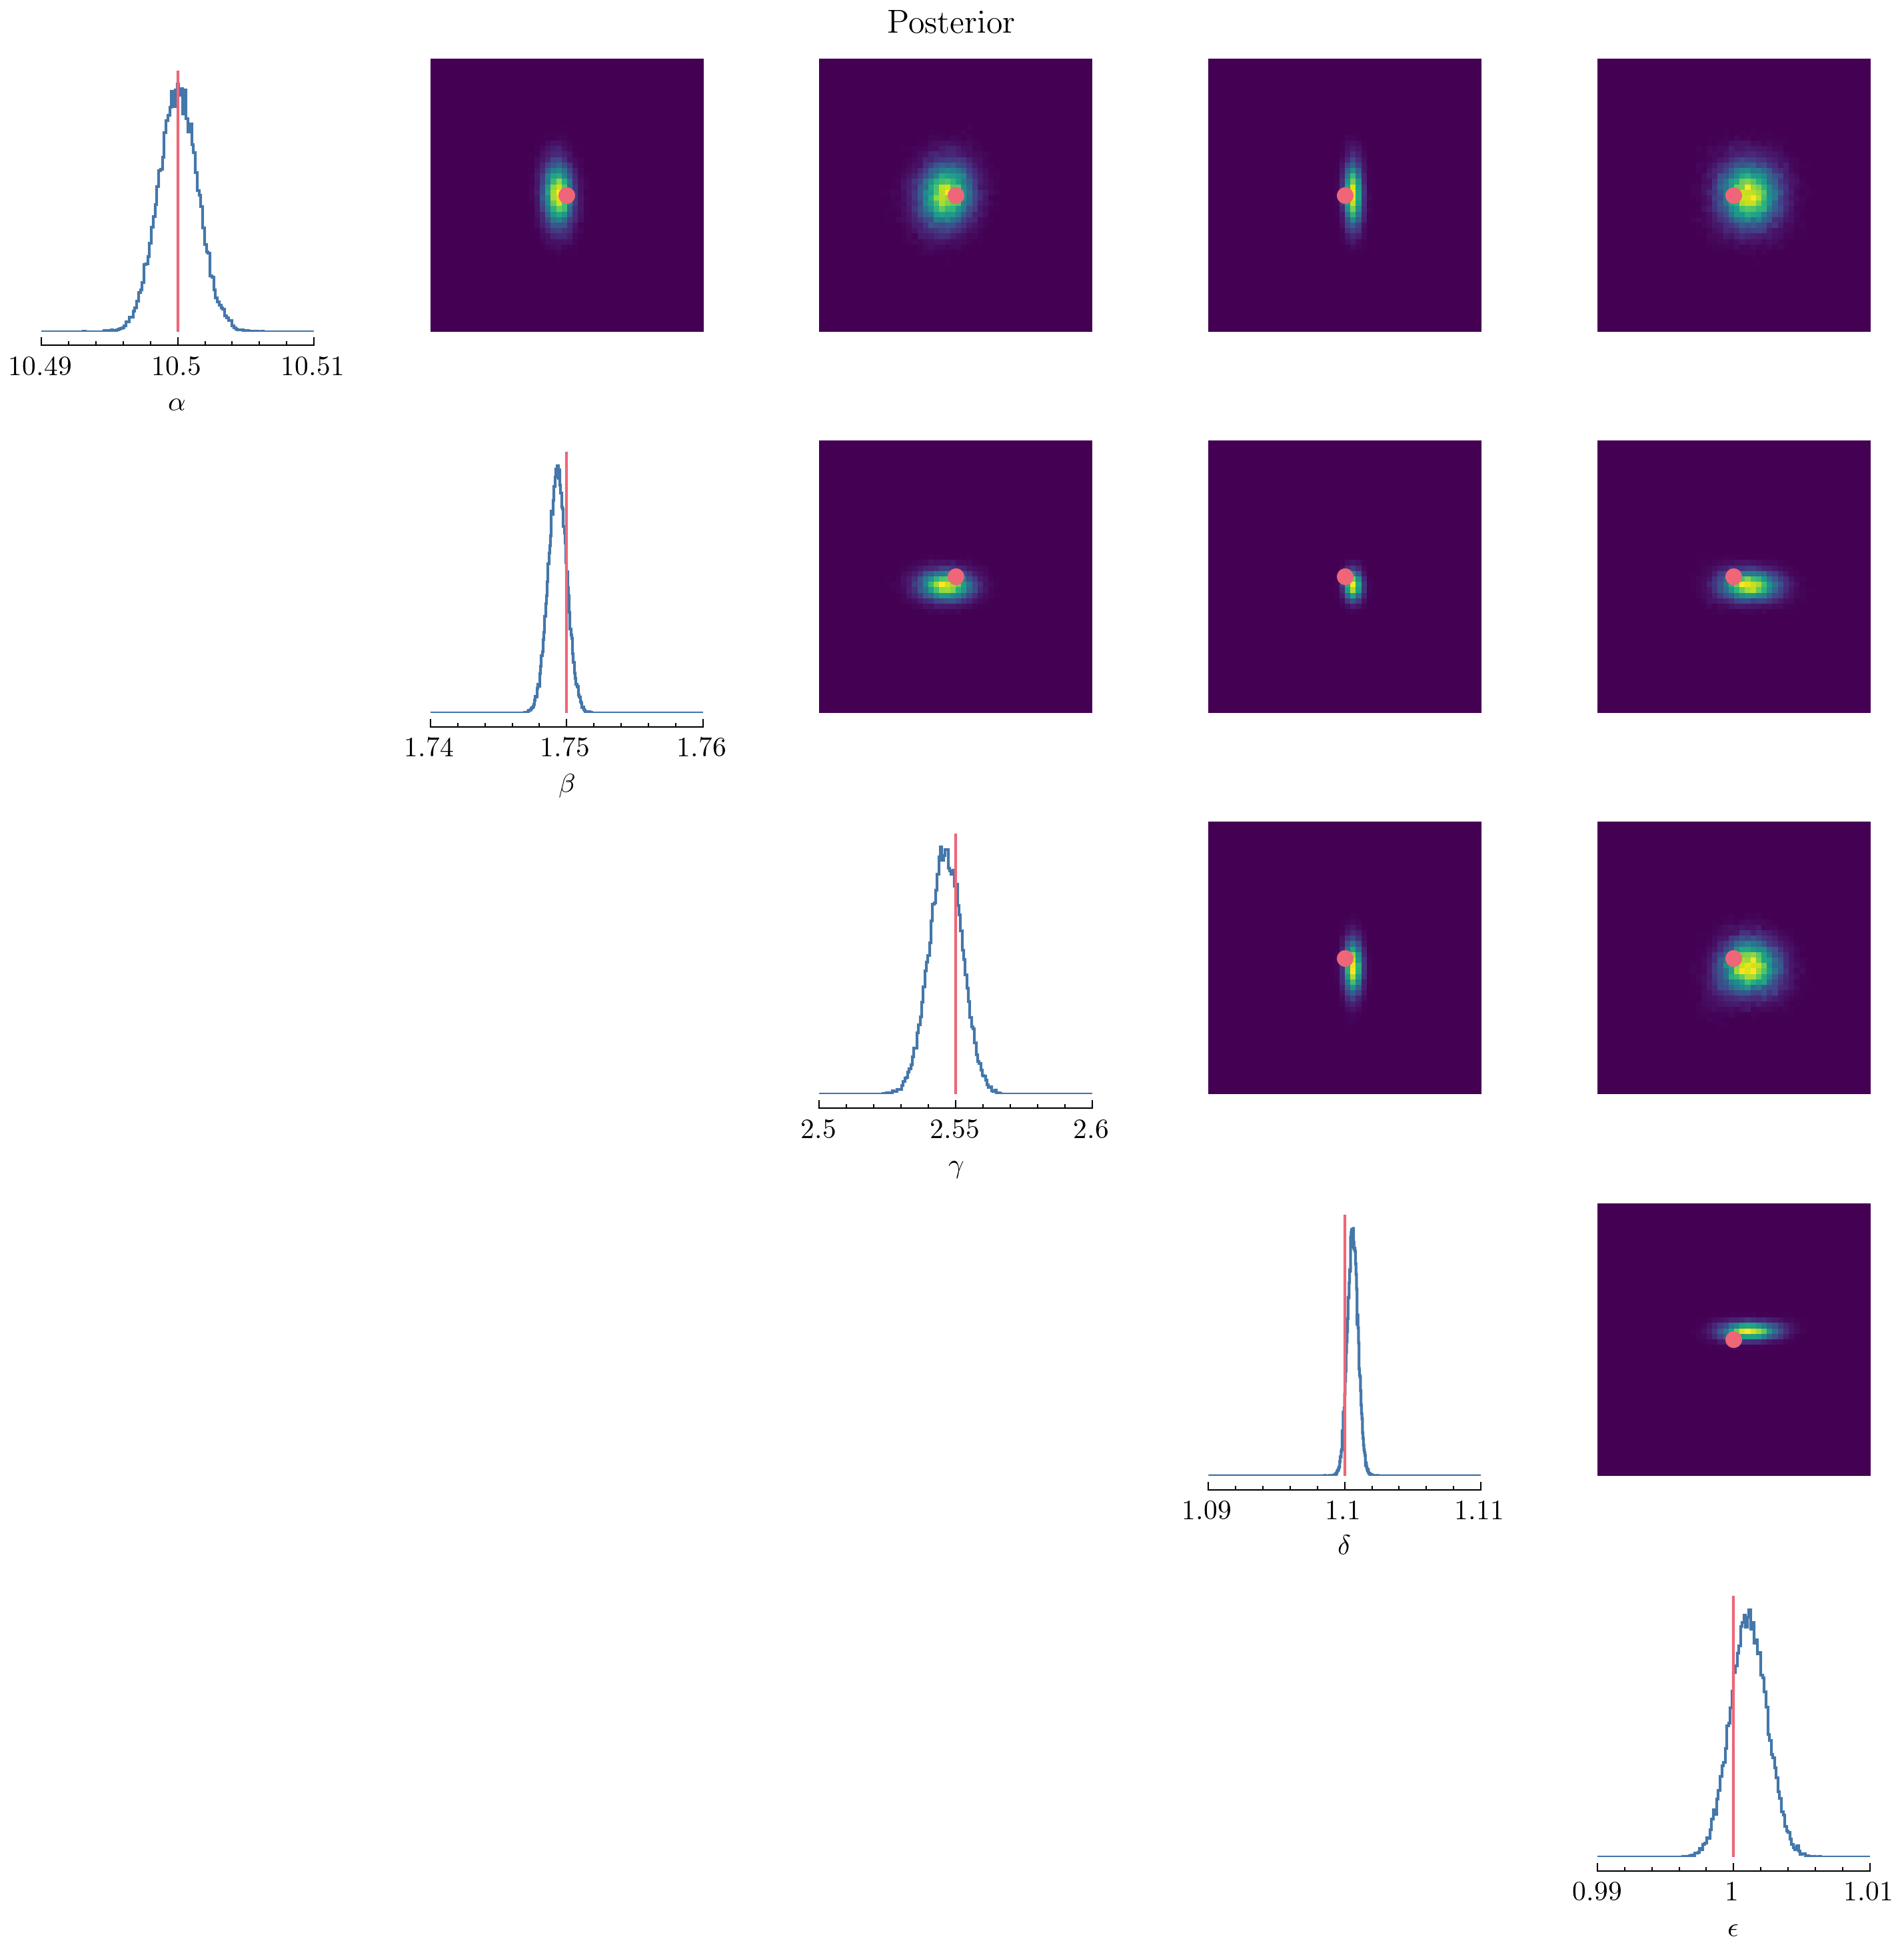

In [15]:
from sbi.analysis import pairplot

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples[0],
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

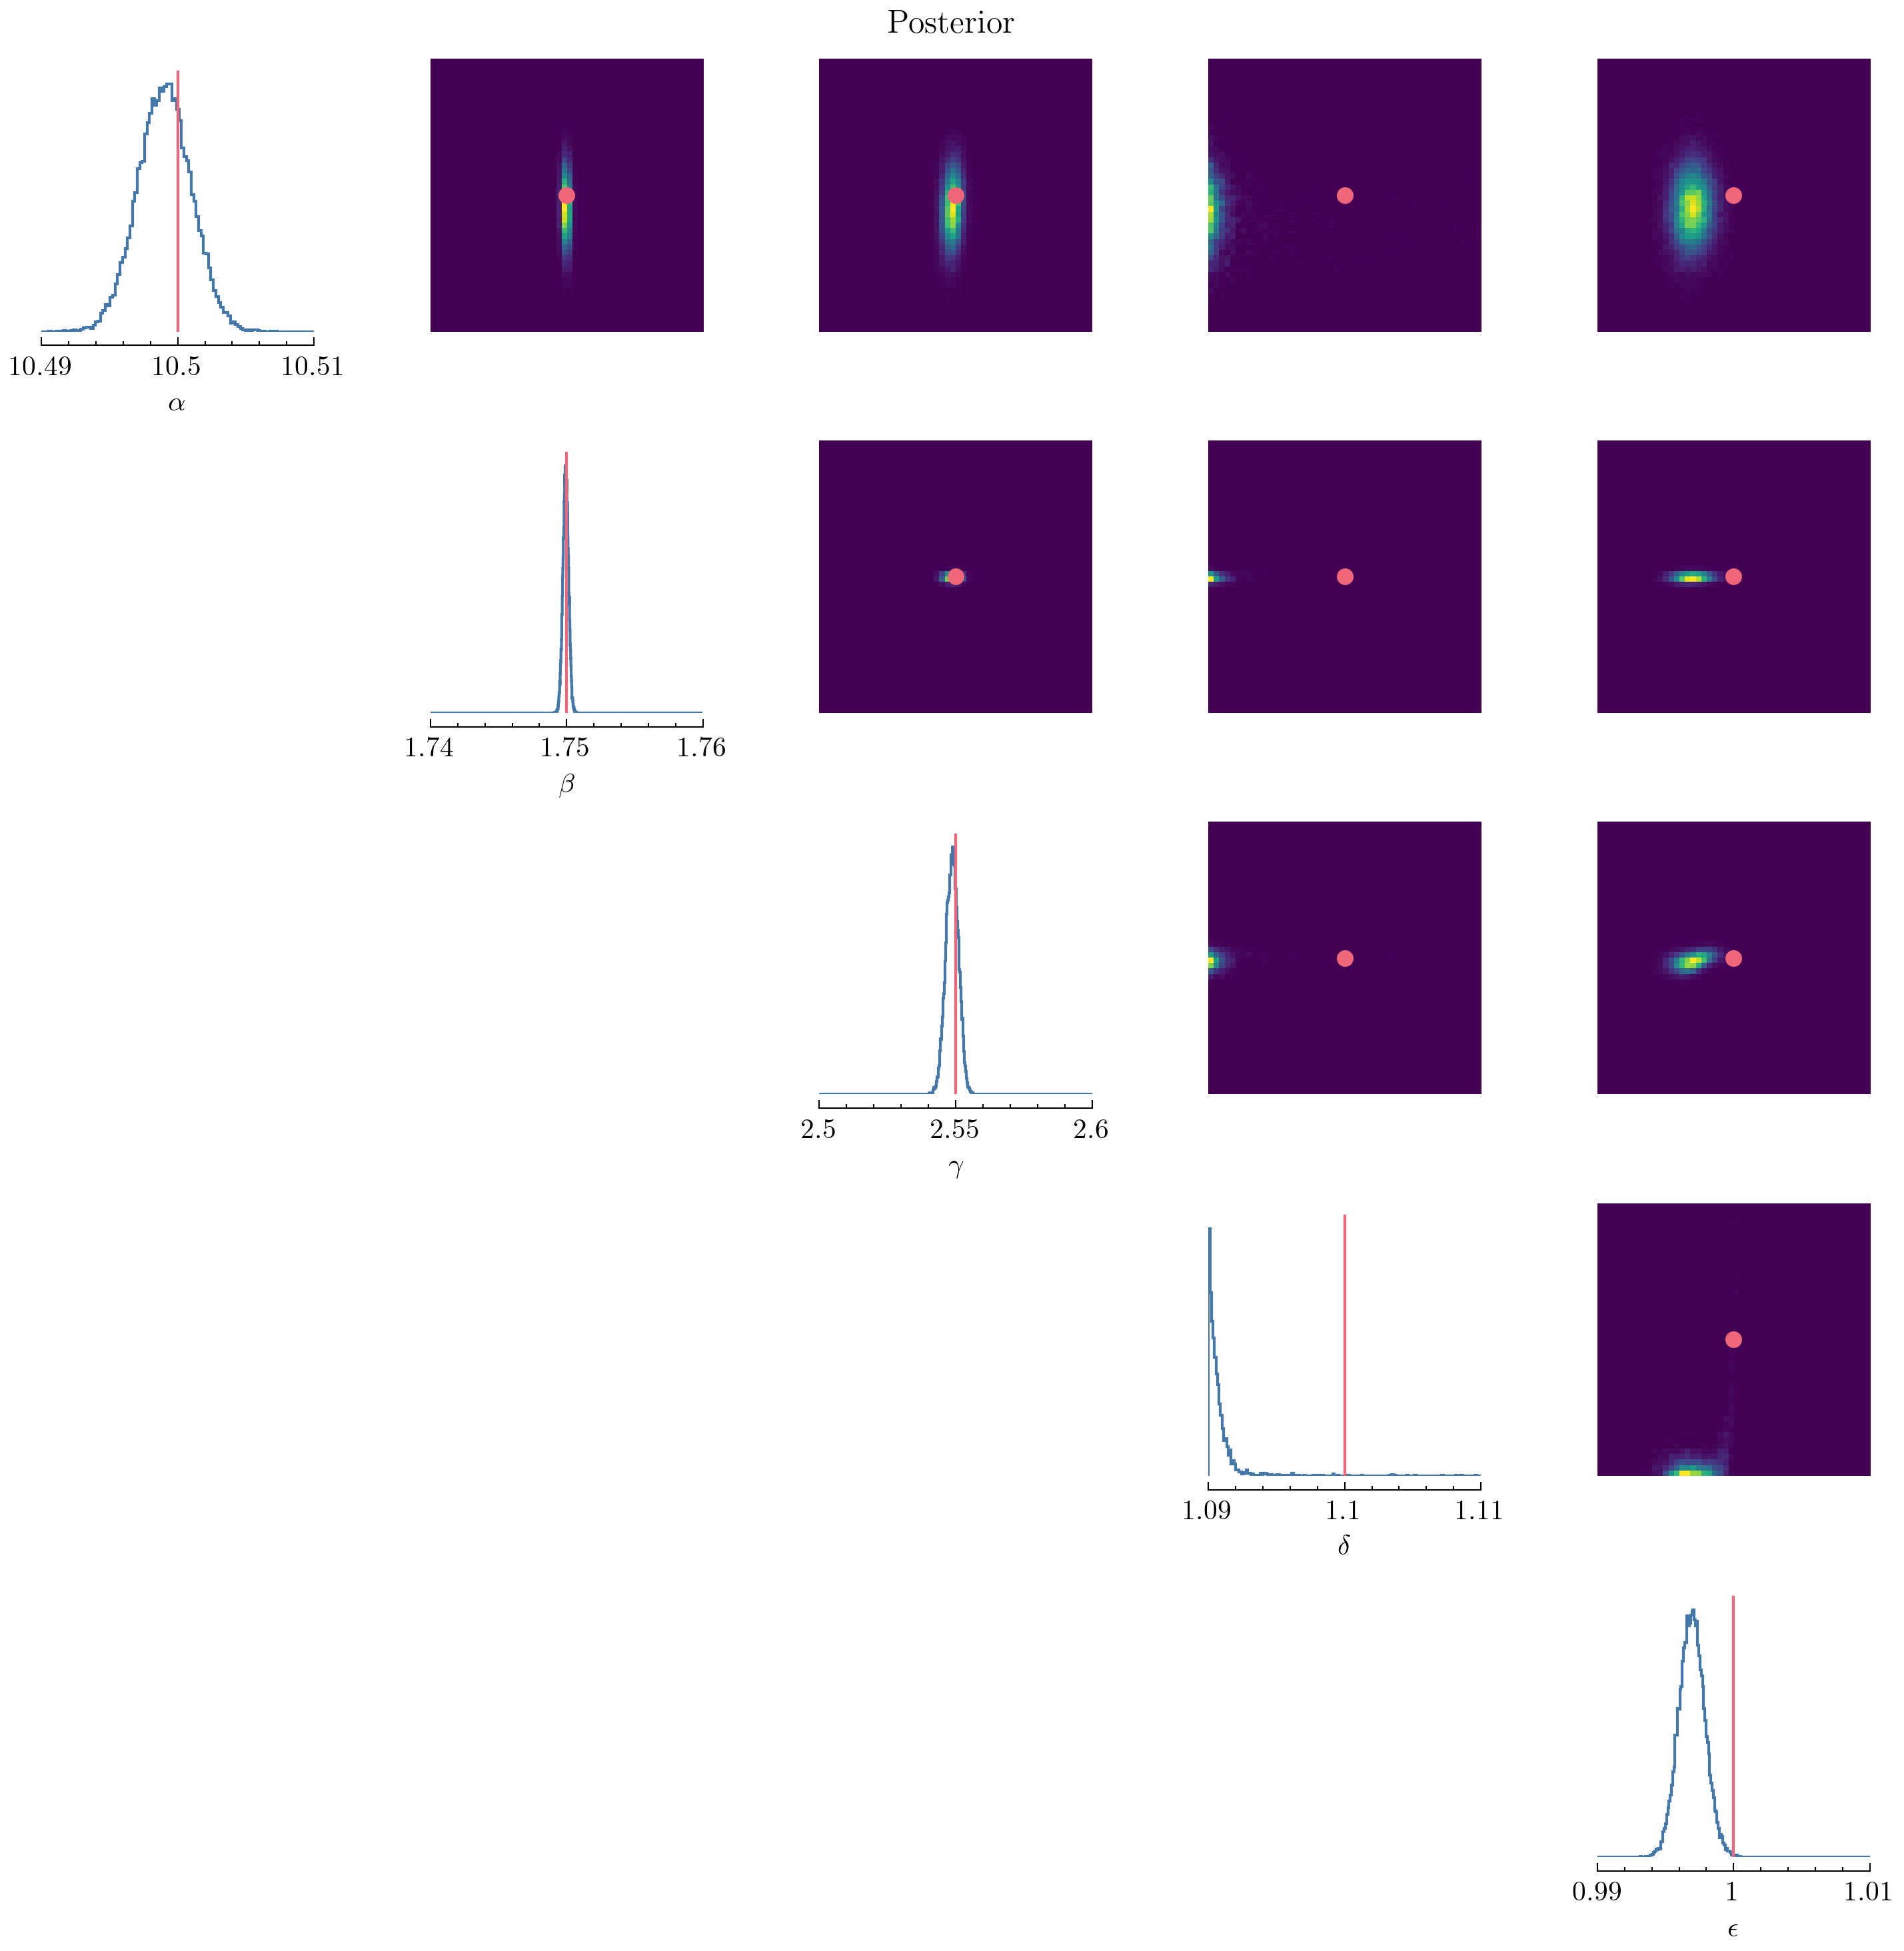

In [16]:
from sbi.analysis import pairplot

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples[1],
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

In [20]:
from sbi.inference import SNPE_C
from sbi.utils import RestrictedPrior, get_density_thresholder

true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)

inference = SNPE_C(prior=prior)
proposal = prior
num_rounds = 2
num_simulations=1000
samples = []

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal=proposal, num_simulations=num_simulations, num_workers=11)
    _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(x_observed)
    samples.append(posterior.sample((25000,)))
    accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
    proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection")
    
print(samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 759.97it/s]


 Neural network successfully converged after 204 epochs.

Drawing 25000 posterior samples: 27506it [00:01, 18260.08it/s]                           
Drawing 1000000 posterior samples: 1000216it [00:51, 19608.27it/s]                            


KeyboardInterrupt: 

In [3]:
from sbi.inference import FMPE, simulate_for_sbi

true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)

inference = FMPE(prior=prior)
theta, x = simulate_for_sbi(simulator_wrapper, proposal=prior, num_simulations=5000, num_workers=11)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator).set_default_x(x_observed)
print(posterior)

100%|██████████| 5000/5000 [00:13<00:00, 358.10it/s] 


 Neural network successfully converged after 161 epochs.Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [5]:
from sbi.analysis import pairplot

samples = posterior.sample((24000,))
param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples[0],
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [6]:
from sbi.inference import NPSE, simulate_for_sbi

true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
x_observed = simulator(true_parameter)

inference = NPSE(prior=prior, sde_type="ve")
theta, x = simulate_for_sbi(simulator_wrapper, proposal=prior, num_simulations=5000, num_workers=11)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator).set_default_x(x_observed)
print(posterior)




























Drawing 25000 posterior samples:   0%|          | 0/25000 [10:24<?, ?it/s]


 Neural network successfully converged after 768 epochs.Posterior p(θ|x) of type ScorePosterior. It samples from the diffusion model given the             score_estimator.


Drawing 24000 posterior samples:   0%|          | 0/24000 [00:00<?, ?it/s]

































































































































Drawing 24000 posterior samples:  41%|████▏     | 9954/24000 [00:16<00:23, 609.34it/s]


























































































Drawing 24000 posterior samples:  41%|████▏     | 9954/24000 [00:27<00:23, 609.34it/s]





















































Drawing 24000 posterior samples:  83%|████████▎ | 19916/24000 [00:33<00:06, 593.71it/s]



































































































Drawing 6151 posterior samples: 100%|██████████| 499/499 [00:10<00:00, 46.43it/s]
Drawing 24000 posterior samples: 26036it [00:44, 589.45it/s]                           
Drawing 24000 posterior samples:   0%|          | 0/24000 [11:55<?, ?it/s]


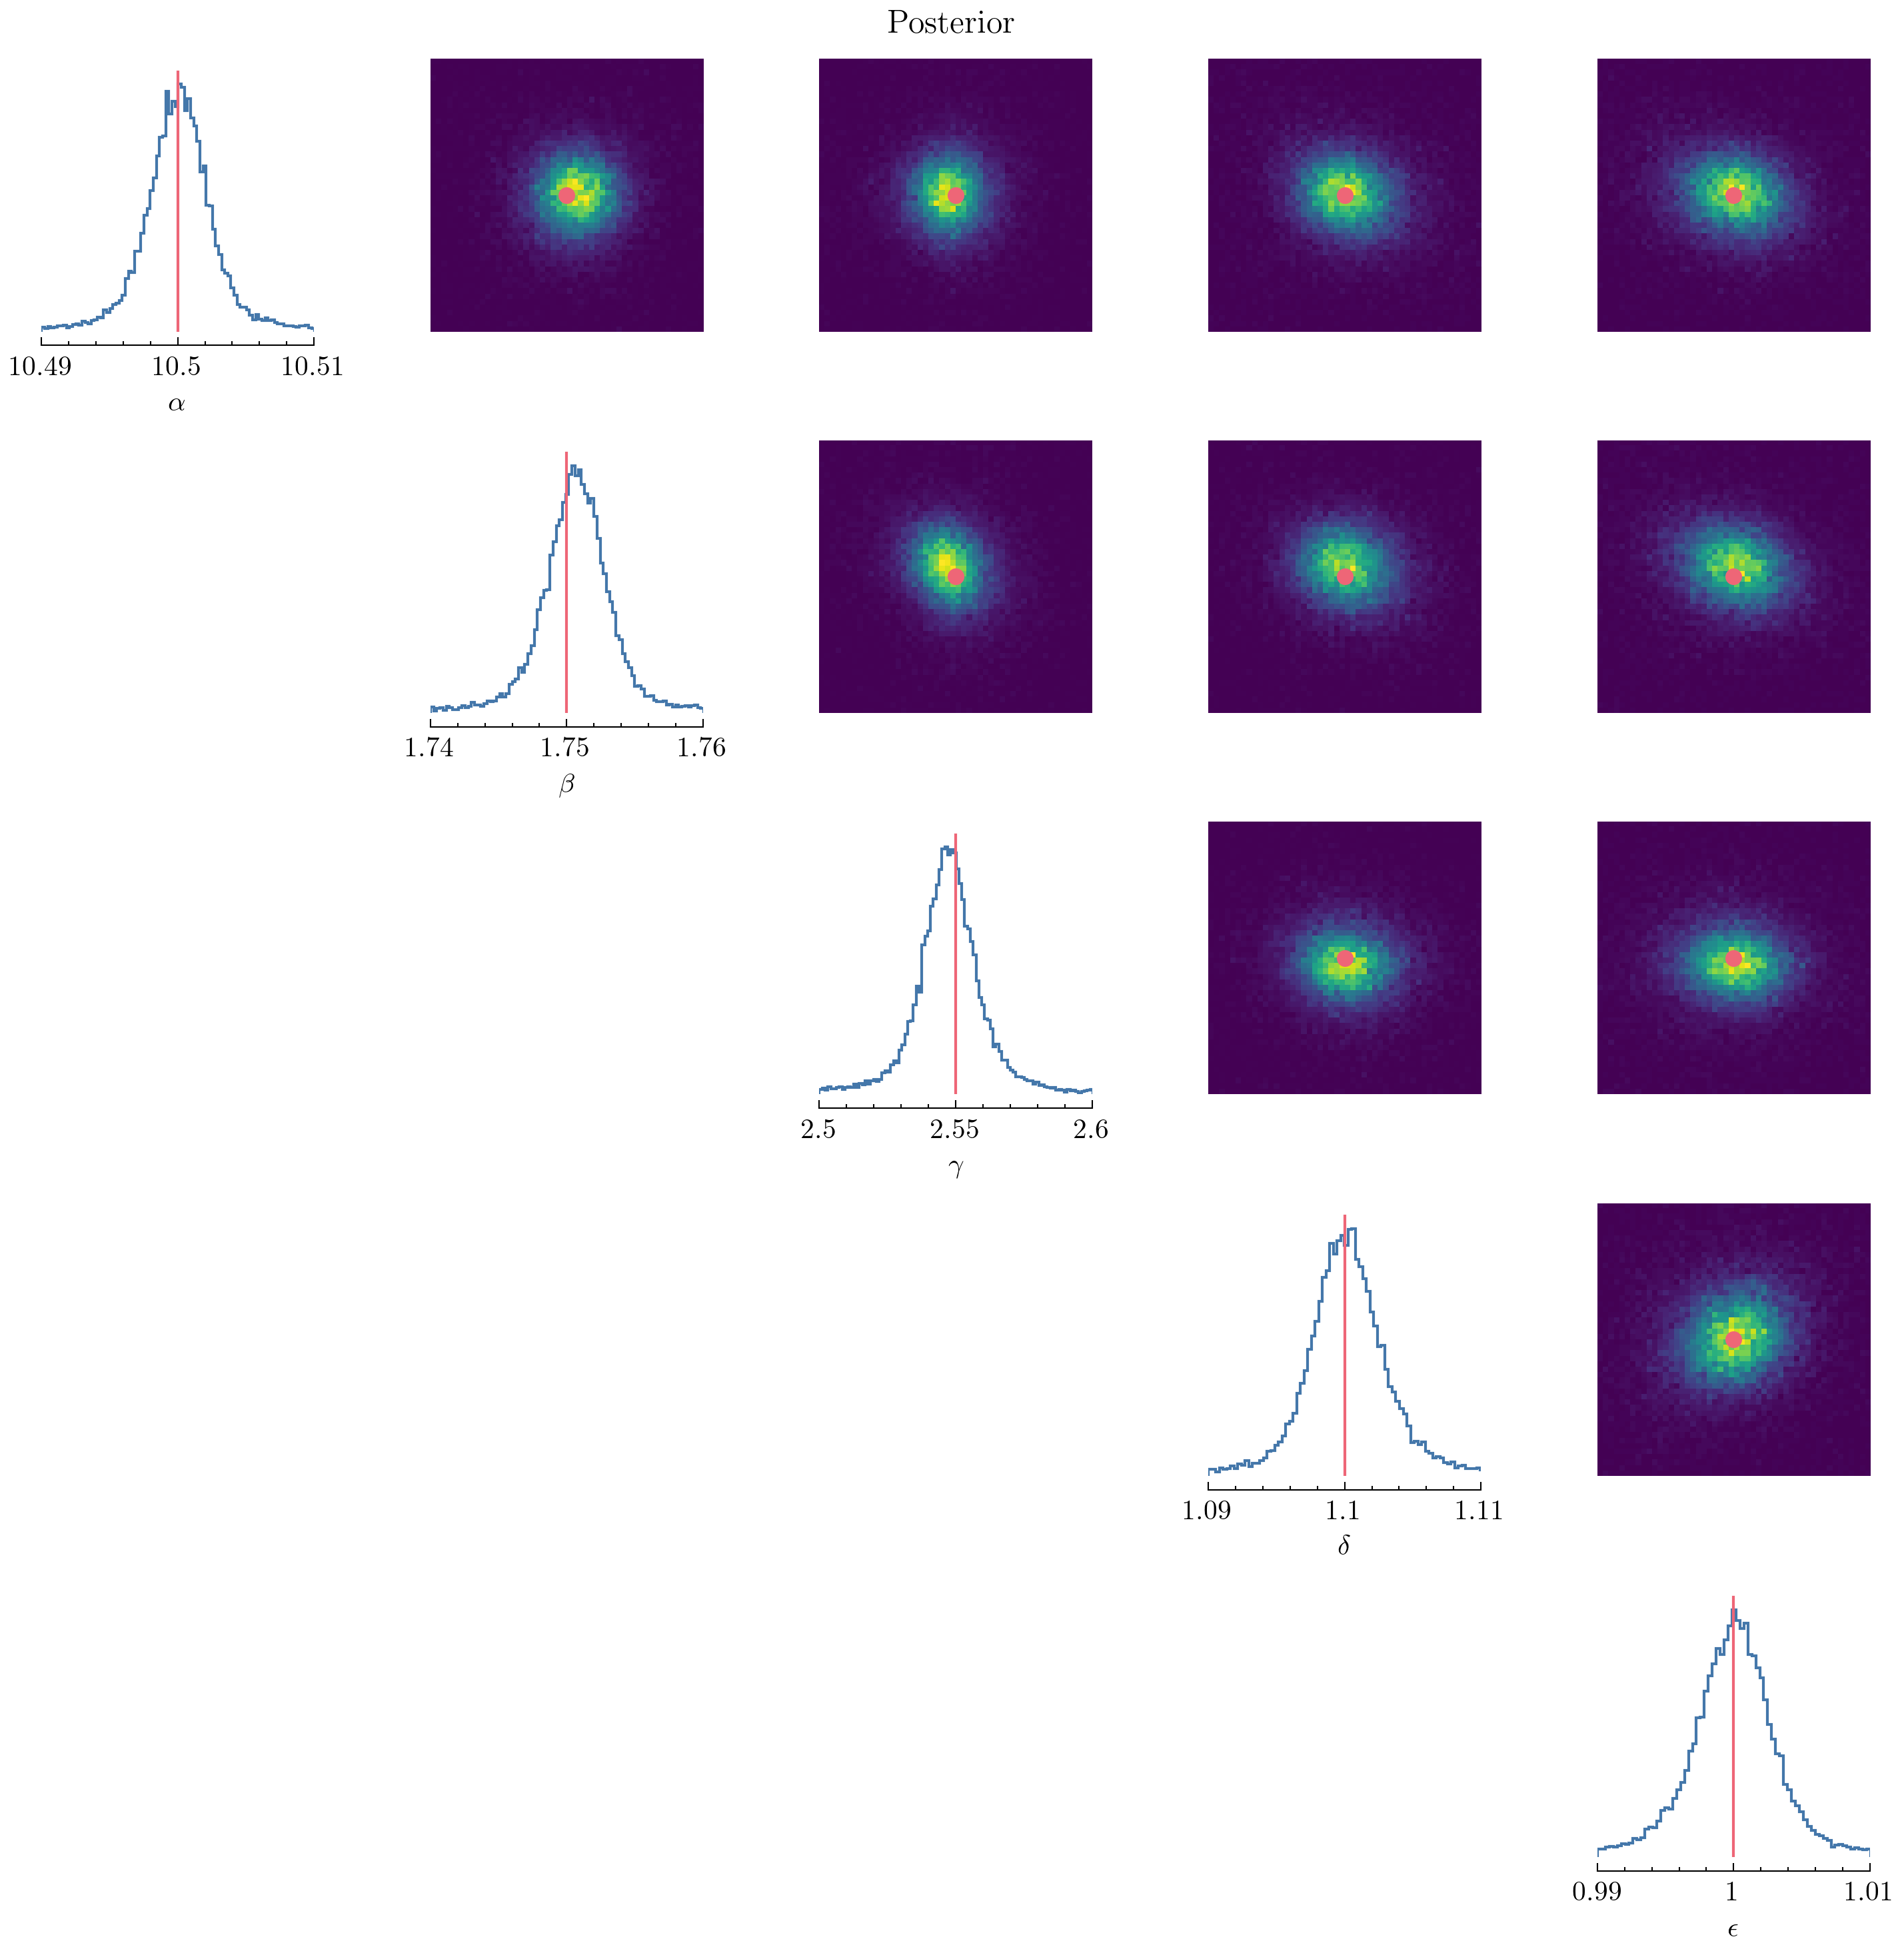

In [8]:
from sbi.analysis import pairplot

samples = posterior.sample((24000,))
param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.5-0.01, 10.5+0.01],    
    [1.75-0.01, 1.75+0.01],  
    [2.55-0.05, 2.55+0.05],      
    [1.1-0.01, 1.1+0.01],    
    [1-0.01, 1+0.01],  
])
true_parameter = torch.tensor([10.5, 1.75, 2.55, 1.1, 1.0])
fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

































































































































































Drawing 10000 posterior samples: 100%|██████████| 499/499 [00:19<00:00, 25.96it/s]





























































































































Drawing 10000 posterior samples: 100%|██████████| 499/499 [00:15<00:00, 31.67it/s]





























































































































Drawing 9051 posterior samples: 100%|██████████| 499/499 [00:14<00:00, 33.71it/s]
Drawing 24000 posterior samples: 26799it [00:49, 538.06it/s]


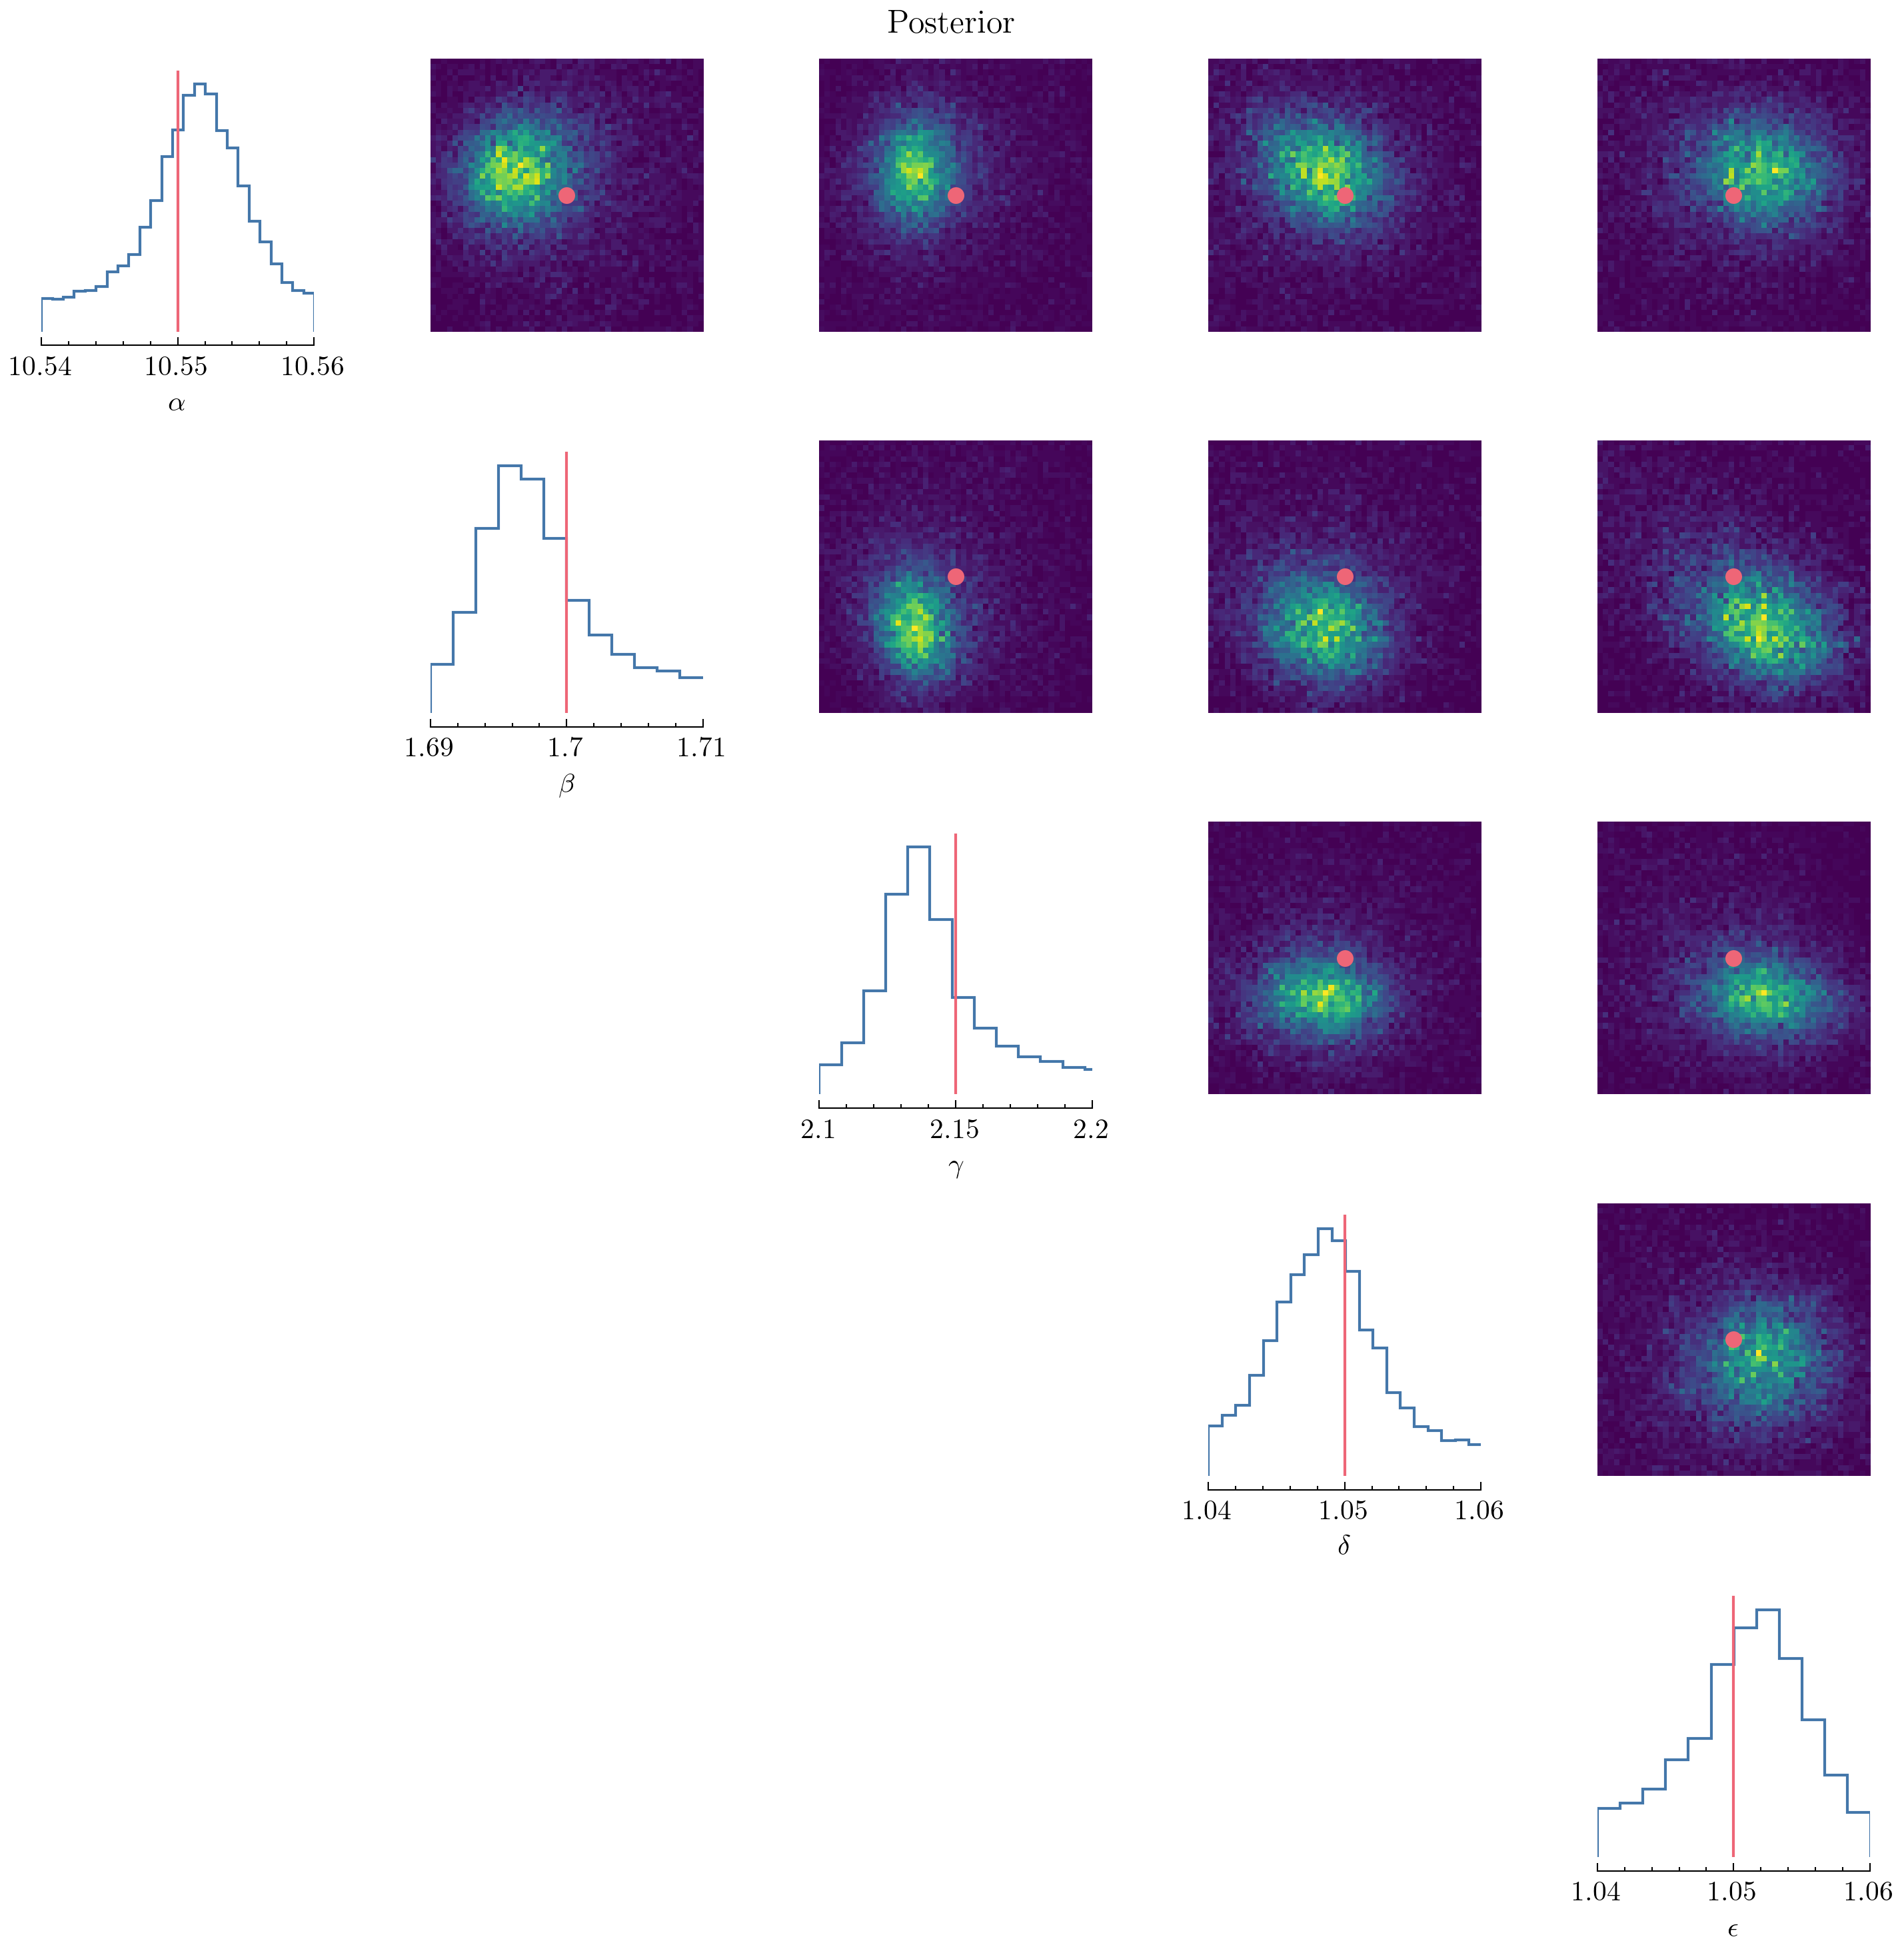

In [21]:
from sbi.analysis import pairplot

true_parameter = torch.tensor([10.55, 1.7, 2.15, 1.05, 1.05])
x_observed = simulator(true_parameter)
posterior = inference.build_posterior(density_estimator).set_default_x(x_observed)
samples = posterior.sample((24000,))

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$']
limits = torch.tensor([
    [10.55-0.01, 10.55+0.01],    
    [1.7-0.01, 1.7+0.01],  
    [2.15-0.05, 2.15+0.05],      
    [1.05-0.01, 1.05+0.01],    
    [1.05-0.01, 1.05+0.01],  
])
true_parameter = torch.tensor([10.55, 1.7, 2.15, 1.05, 1.05])
fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

In [14]:
num_tarp_samples = 200

inference = NPSE(prior=prior)
posterior = inference.build_posterior(density_estimator)
thetas, xs = simulate_for_sbi(simulator_wrapper, proposal=prior, num_simulations=num_tarp_samples, num_workers=11)






100%|██████████| 200/200 [00:00<00:00, 381.34it/s]


In [16]:
from sbi.diagnostics import run_tarp
from sbi.analysis.plot import plot_tarp

expected_coverage, ideal_coverage = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,  
    num_posterior_samples=1000,
    use_batched_sampling=False,
    num_workers=11
)















































































































Sampling 200 times (1000,) posterior samples.: 100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


(<Figure size 1800x1800 with 1 Axes>,
 <Axes: xlabel='Credibility Level $\\alpha$', ylabel='Expected Coverage Probability'>)

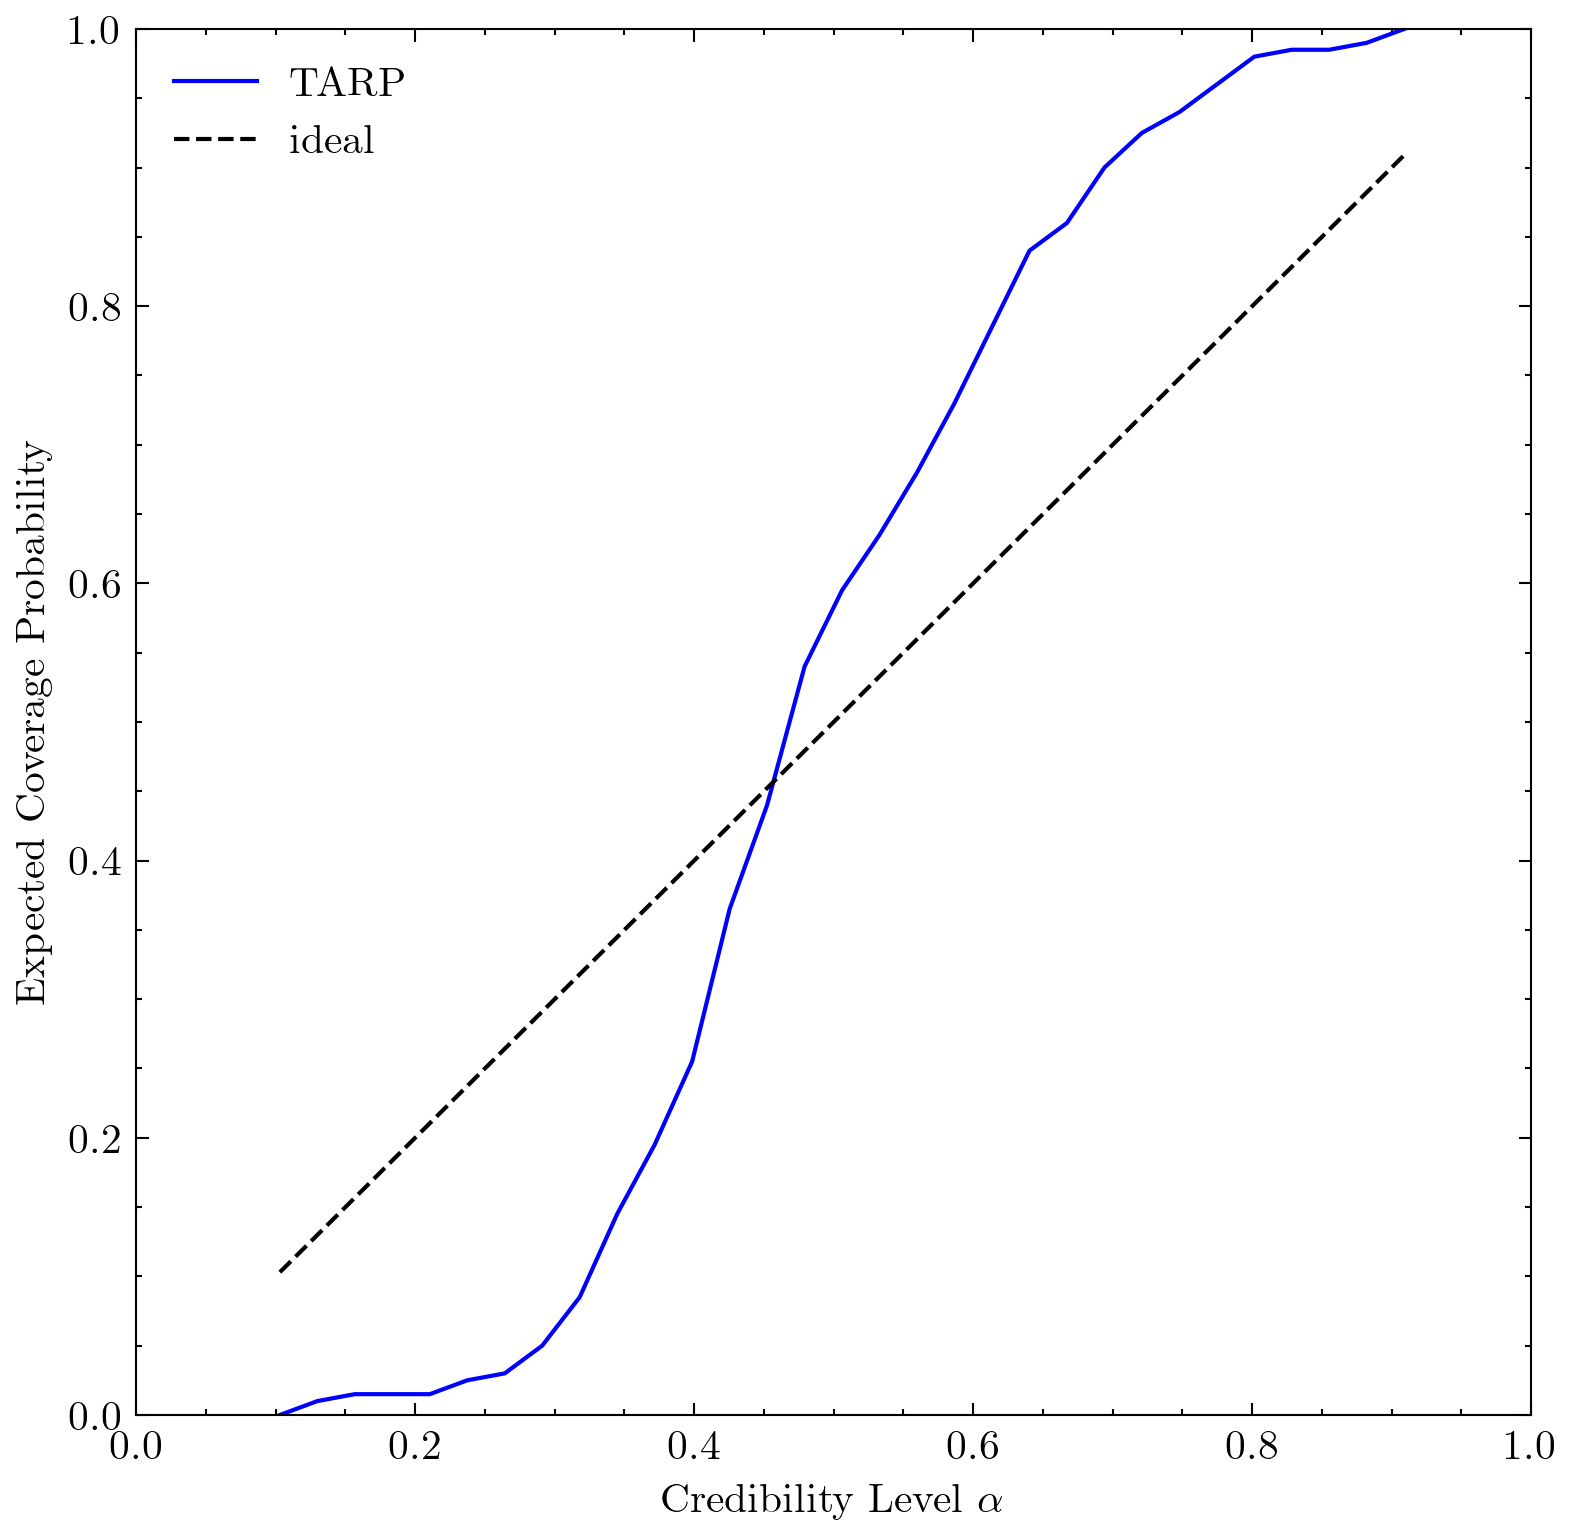

In [18]:
plot_tarp(expected_coverage, ideal_coverage)